In [13]:
from IPython.display import display, HTML
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import hashlib
import wandb
import time
import os
import io

In [14]:
class Activation:
    """Base class for activation functions."""
    def forward(self, x):
        raise NotImplementedError
    
    def backward(self, grad_output):
        raise NotImplementedError
        
    def __str__(self):
        return self.__class__.__name__

class Identity(Activation):
    """Identity activation function (no activation)."""
    def forward(self, x):
        self.input = x
        return x
    
    def backward(self, grad_output):
        return grad_output

class ReLU(Activation):
    """ReLU activation function."""
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)
    
    def backward(self, grad_output):
        return grad_output * (self.input > 0)

class Tanh(Activation):
    """Tanh activation function."""
    def forward(self, x):
        self.output = np.tanh(x)
        return self.output
    
    def backward(self, grad_output):
        return grad_output * (1 - self.output**2)

class Sigmoid(Activation):
    """Sigmoid activation function."""
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output
    
    def backward(self, grad_output):
        return grad_output * (self.output * (1 - self.output))

In [15]:
class Linear:
    """  Fully connected linear layer with activation function."""
    def __init__(self, input_dim, output_dim, activation=Identity(), rng = np.random.default_rng(42)):
        self.input_dim = input_dim
        self.output_dim = output_dim
        if isinstance(activation, ReLU):
            limit = np.sqrt(6 / (input_dim))
        else:
            limit = np.sqrt(6 / (input_dim + output_dim))
        self.activation = activation
        self.rng = rng
        self.weights = self.rng.uniform(-limit, limit, (input_dim, output_dim))
        self.biases = np.zeros((1, output_dim))
        self.input = None
        self.output = None   
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.zeros_like(self.biases)
    
    def forward(self, x):
        """ Forward pass """
        self.input = x
        pre_activation = x @ self.weights + self.biases
        self.output = self.activation.forward(pre_activation)
        return self.output
    
    def backward(self, grad_output):
        """ Backward pass """
        grad_pre_activation = self.activation.backward(grad_output)
        self.grad_weights += self.input.T @ grad_pre_activation
        self.grad_biases += np.sum(grad_pre_activation, axis=0, keepdims=True)
        grad_input = grad_pre_activation @ self.weights.T
        return grad_input

    def update(self, learning_rate):
        """Update parameters using accumulated gradients"""
        self.weights -= learning_rate * self.grad_weights
        self.biases -= learning_rate * self.grad_biases

    def zero_grad(self):
        """Reset accumulated gradients to zero"""
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.zeros_like(self.biases)

    def get_params(self):
        """Returns the layer's parameters in a dictionary."""
        return {'weights': self.weights, 'biases': self.biases}

    def set_params(self, params):
        """Sets the layer's parameters from a dictionary."""
        self.weights = params['weights']
        self.biases = params['biases']
    
    def set_parameters_dtype(self, dtype):
        """Casts the weights and biases to a specified data type."""
        self.weights = self.weights.astype(dtype)
        self.biases = self.biases.astype(dtype)

In [16]:
class Loss:
    """Base class for loss functions."""
    def forward(self, y_pred, y_true):
        raise NotImplementedError
        
    def backward(self, y_pred, y_true):
        raise NotImplementedError

class MSE(Loss):
    """Mean Squared Error Loss."""
    def forward(self, y_pred, y_true):
        return np.mean((y_pred - y_true)**2)
    
    def backward(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.shape[0]

class BCE(Loss):
    """Binary Cross Entropy Loss."""
    def forward(self, y_pred, y_true):
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def backward(self, y_pred, y_true):
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return (y_pred - y_true) / (y_pred * (1 - y_pred)) / y_true.shape[0]

In [17]:
class Model:
    """A neural network model composed of a list of layers."""
    def __init__(self, layers, loss_fn):
        self.layers = layers
        self.loss_fn = loss_fn

    def forward(self, x):
        """Sequentially execute the forward pass in each layer."""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad):
        """Sequentially execute the backward pass in reverse order."""
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def train(self, x, y):
        """Perform a single training step: forward, loss, backward."""
        y_pred = self.forward(x)
        loss = self.loss_fn.forward(y_pred, y)
        initial_grad = self.loss_fn.backward(y_pred, y)
        self.backward(initial_grad)
        return loss

    def zero_grad(self):
        """Reset gradients in all layers to zero."""
        for layer in self.layers:
            layer.zero_grad()

    def update(self, learning_rate):
        """Update parameters in all layers and then zero the gradients."""
        for layer in self.layers:
            layer.update(learning_rate)
        self.zero_grad()

    def predict(self, x):
        """Perform a forward pass to get a prediction."""
        return self.forward(x)

    def save_to(self, path):
        """Save all model parameters to a .npz file."""
        params = {f'layer_{i}_{k}': v for i, l in enumerate(self.layers) 
                  for k, v in l.get_params().items()}
        np.savez(path, **params)
        return

    def load_from(self, path):
        """Load model parameters from a .npz file."""
        data = np.load(path)
        for i, layer in enumerate(self.layers):
            weights = data[f'layer_{i}_weights']
            biases = data[f'layer_{i}_biases']
            
            if weights.shape != layer.weights.shape or biases.shape != layer.biases.shape:
                raise ValueError(
                    f"Shape mismatch in layer {i}. Expected weights {layer.weights.shape} "
                    f"and biases {layer.biases.shape}, but got {weights.shape} and {biases.shape}."
                )
            layer.set_params({'weights': weights, 'biases': biases})
        return

In [18]:
class FeaturePipeline:
    """Encapsulates logic for Feature Expansions and Normalization)."""
    def __init__(self, method, order, freq):
        self.method = method
        self.order = order
        self.freq = freq

    def create_features(self, coords):
        if self.method == "Raw": 
            raw_feats = self._get_raw(coords)
        elif self.method == "Polynomial": 
            raw_feats = self._get_polynomial(coords)
        elif self.method == "Fourier": 
            raw_feats = self._get_fourier(coords)
        else: 
            raise ValueError(f"Unknown method: {self.method}")
        return self._normalize_features(raw_feats)
    
    def _normalize_features(self, feats):
        if self.method in ["Raw", "Fourier"]: 
            return feats
        elif self.method == "Polynomial":
            max_abs = np.max(np.abs(feats), axis=0, keepdims=True)
            max_abs[max_abs == 0] = 1.0
            return feats / max_abs
        
    def _get_raw(self, coords):
        return coords
    
    def _get_polynomial(self, coords):
        coords_norm = 2 * (coords - 0.5)
        x, y = coords_norm[:, 0:1], coords_norm[:, 1:2]
        features = [ (x**(i-j)) * (y**j) for i in range(1, self.order+1) for j in range(i+1) ]
        return np.concatenate(features, axis=1)
    
    def _get_fourier(self, coords):
        freqs = np.arange(1, self.freq + 1)
        sines = np.sin(2 * np.pi * coords[..., None] * freqs)
        cosines = np.cos(2 * np.pi * coords[..., None] * freqs)
        return np.concatenate([sines.reshape(coords.shape[0], -1), cosines.reshape(coords.shape[0], -1)], axis=1)

In [33]:
class Modular_Dataloader:
    """
    Loads an image, creates a coordinate dataset, and applies feature transformations.
    """
    def __init__(self, img_path, image_type, method, order=None, freq=None):
        self.img_path = img_path
        self.image_type = image_type
        self.feature_extractor = FeaturePipeline(method, order=order, freq=freq)

        self.X = None
        self.y = None
        self.image_shape = None

    def load_and_process_data(self):
        """Loads the image from disk, processes it, and generates features."""
        original_image = Image.open(self.img_path).resize((256, 256), Image.Resampling.LANCZOS)
        if self.image_type == "Gray":
            original_image = original_image.convert('L')
        
        normalized_image = np.array(original_image).astype(np.float32) / 255.0
        self.image_shape = normalized_image.shape
        self.y = normalized_image.reshape(-1, 1 if self.image_type == "Gray" else 3)

        height, width = self.image_shape[:2]
        x_coords = np.linspace(0, 1, width, endpoint=True)
        y_coords = np.linspace(0, 1, height, endpoint=True)
        xx, yy = np.meshgrid(x_coords, y_coords)
        coords = np.stack([xx.ravel(), yy.ravel()], axis=-1)
        self.X = self.feature_extractor.create_features(coords)

    def get_data(self):
        return self.X, self.y, self.image_shape


In [34]:
class ImageReconstructionTask:
    """Manages a single image reconstruction experiment."""
    def __init__(self, img_path, img_type, feature_config, mlp_config, train_config, name, username=None):
        self.name = name
        self.username = username
        self.rng = np.random.default_rng(seed=abs(hash(self.username)) % (2**32))
        self.img_path = img_path
        self.img_type = img_type
        self.feature_config = feature_config
        self.mlp_config = mlp_config
        self.train_config = train_config
        self.dataloader = Modular_Dataloader(img_path, 
                                             img_type, 
                                             feature_config['method'], 
                                             feature_config.get('order'), 
                                             feature_config.get('freq')
                                             )

        self.run_folder = os.path.join(f"Q2_results/{self.name}_{int(time.time())}")
        os.makedirs(self.run_folder, exist_ok=True)
        self.X = None
        self.y = None
        self.image_shape = None
    
    def _build_model(self):
        input_dim, output_dim = self.X.shape[1], self.y.shape[1]
        layers = []
        last_dim = input_dim
        for h_dim in self.mlp_config['hidden_dims']:
            layers.append(Linear(last_dim, h_dim, ReLU(), rng=self.rng))
            last_dim = h_dim
        layers.append(Linear(last_dim, output_dim, Sigmoid(), rng=self.rng))
        self.model = Model(layers, MSE())

    def save_epoch_image(self, epoch):
        """
        Generates a full image from the model's predictions and saves it to a file.
        """
        predicted_pixels = self.model.predict(self.X)
        reconstructed_image_np = (np.clip(predicted_pixels, 0, 1) * 255).astype(np.uint8)
        reconstructed_image = Image.fromarray(reconstructed_image_np.reshape(self.image_shape))

        if self.username:
            is_grayscale = (reconstructed_image.mode == 'L')
            if not is_grayscale:
                reconstructed_image = reconstructed_image.convert('RGBA')
            draw = ImageDraw.Draw(reconstructed_image)
            position = (reconstructed_image.width - 10, 10)
            corner_patch = reconstructed_image_np[0:20, -20:]
            if len(corner_patch.shape) == 3: 
                brightness = np.mean(corner_patch[:,:,0] * 0.299 + corner_patch[:,:,1] * 0.587 + corner_patch[:,:,2] * 0.114)
            else: 
                brightness = np.mean(corner_patch)
                
            if brightness > 128:
                text_color = 0 if is_grayscale else (0, 0, 0, 128) 
            else:
                text_color = 255 if is_grayscale else (255, 255, 255, 128) 

            draw.text(position, self.username, fill=text_color, anchor="rt")

        images_dir = os.path.join(self.run_folder, "epoch_images")
        os.makedirs(images_dir, exist_ok=True)
        image_path = os.path.join(images_dir, f"epoch_{epoch+1:04d}.png")
        reconstructed_image.save(image_path)

    def _train(self):
        start_time = time.time()
        history = {'loss': []}
        num_samples, indices = self.X.shape[0], np.arange(self.X.shape[0])
        iterator = tqdm(range(self.train_config["epochs"]), desc=f"Training {self.feature_config['method']}")
        for epoch in iterator:
            self.rng.shuffle(indices)
            X_shuffled, y_shuffled = self.X[indices], self.y[indices]
            epoch_loss = 0
            for i in range(0, num_samples, self.train_config["batch_size"]):
                x_batch, y_batch = X_shuffled[i:i+self.train_config["batch_size"]], y_shuffled[i:i+self.train_config["batch_size"]]
                epoch_loss += self.model.train(x_batch, y_batch) * len(x_batch)
                self.model.update(self.train_config["learning_rate"])
            avg_epoch_loss = epoch_loss / num_samples; history['loss'].append(avg_epoch_loss)
            iterator.set_postfix({"loss": f"{avg_epoch_loss:.6f}"})
            self.save_epoch_image(epoch)
        total_time = time.time() - start_time
        return {"Method": self.feature_config['method'], "Param": self.feature_config.get('order') or self.feature_config.get('freq'),
                "Final Loss": history['loss'][-1], "Total Time (s)": total_time,
                "Input Features": self.X.shape[1], "loss_history": history['loss'], "name": self.name, "run_folder": self.run_folder}
    def run_pipeline(self):
        self.dataloader.load_and_process_data()
        self.X, self.y, self.image_shape = self.dataloader.get_data()
        self._build_model()
        return self._train()

In [ ]:
def display_summary_table(results):
    """Generates the summary table"""
    df = pd.DataFrame(results)
    df_display = df.drop(columns=['loss_history', 'run_folder', 'name'])
    display(HTML("<h2>Experiment Results Summary</h2>"))
    display(df_display)

def create_comparison_gif(image_name, results, num_epochs, username=None):
    """Generates the 1x3 comparison GIF."""
    frames, methods = [], ["Raw", "Polynomial", "Fourier"]
    run_data = { r['Method']: r for r in results if image_name in r.get('name', '') }
    if len(run_data) < 3:
        print(f"Warning: Could not find all 3 methods for '{image_name}' to create GIF.")
        return

    for epoch in tqdm(range(num_epochs), desc=f"Generating GIF for '{image_name}'"):
        fig, axes = plt.subplots(1, 3, figsize=(18, 7))
        fig.suptitle(f"Reconstruction Progress - Epoch {epoch + 1}", fontsize=16)
        
        for i, method in enumerate(methods):
            ax, data = axes[i], run_data[method]
            img_path = os.path.join(data['run_folder'], "epoch_images", f"epoch_{epoch+1:04d}.png")
            try:
                image = Image.open(img_path)
                ax.imshow(image, cmap='gray' if 'smiley' in image_name else None)
            except FileNotFoundError:
                ax.imshow(np.zeros((256, 256, 3), dtype=np.uint8))
            ax.set_title(f"{method} (Loss: {data['loss_history'][epoch]:.4f})")
            ax.axis('off')
            inset_ax = ax.inset_axes([0.03, 0.03, 0.4, 0.2])
            inset_ax.plot(data['loss_history'], 'r-') 
            inset_ax.axvline(x=epoch, c='b', ls='--')
            inset_ax.set_title("Loss", fontsize=8) 
            inset_ax.tick_params(labelsize=6)

        if username: 
            plt.text(0.98, 0.02, username, ha='right', va='bottom', transform=fig.transFigure, c='gray', alpha=0.7)
        buf = io.BytesIO(); fig.savefig(buf, format='png')
        buf.seek(0)
        frames.append(Image.open(buf))
        plt.close(fig)

    output_filename = f"{image_name}_comparison.gif"
    if frames:
        frames[0].save(output_filename, save_all=True, append_images=frames[1:], duration=150, loop=0)
        print(f"GIF saved to '{output_filename}'")

def plot_blur_analysis(results, username=None):
    """Generates the linear and log scale plots"""
    df_blur = pd.DataFrame(results)
    df_blur['Blur Level'] = df_blur['name'].str.extract(r'blur_(\d+)').astype(int)
    base_results = df_blur[df_blur['Method'] == 'Raw']
    fourier_results = df_blur[df_blur['Method'] == 'Fourier']

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle("Reconstruction Loss vs. Gaussian Blur Level", fontsize=16)

    for ax, scale in zip(axes, ['linear', 'log']):
        ax.plot(base_results["Blur Level"], base_results["Final Loss"], 'o-', label="BASE (Raw)")
        ax.plot(fourier_results["Blur Level"], fourier_results["Final Loss"], 's-', label="FOURIER (k=5)")
        ax.set_yscale(scale)
        ax.set_title(f"({scale.title()} Scale)")
        ax.set_xlabel("Blur Level (σ)")
        ax.set_ylabel("Final Loss")
        ax.legend()
        ax.grid(True)
        if username:
            ax.text(0.98, 0.98, username, ha='right', va='top', transform=ax.transAxes, c='gray', alpha=0.7)
        plt.savefig(f"blur_analysis_{scale}_scale.png")
    plt.show()

In [40]:
def generate_experiment_configs(base_image_configs, feature_tests, mlp_config, base_train_config):
    """ Programmatically generates a list of experiment configurations. """
    all_configs = []
    for base_img in base_image_configs:
        all_configs.append({
            "img_path": base_img["path"],
            "img_type": base_img["type"],
            "feature_config": {"method": "Raw"},
            "mlp_config": mlp_config,
            "train_config": {**base_train_config, "epochs": base_img["epochs"]},
            "name": f"{base_img['name']}_raw"
        })

        for method_name, param_name, param_values in feature_tests:
            for value in param_values:
                all_configs.append({
                    "img_path": base_img["path"],
                    "img_type": base_img["type"],
                    "feature_config": {"method": method_name, param_name: value},
                    "mlp_config": mlp_config,
                    "train_config": {**base_train_config, "epochs": base_img["epochs"]},
                    "name": f"{base_img['name']}_{method_name.lower()}_{value}"
                })         
    return all_configs

In [41]:
mlp_config = {'hidden_dims': [64, 128, 128]}
train_config = {"learning_rate": 0.1, "batch_size": 128}
smiley_path = "/home/detour/Documents/SMAI/Assignments/assignment3/Datasets/Q2/smiley.png"
cat_path = "/home/detour/Documents/SMAI/Assignments/assignment3/Datasets/Q2/cat.jpg"
blurred_dir = "/home/detour/Documents/SMAI/Assignments/assignment3/Datasets/Q2/blurred"
username = "reddy.bathula"
base_images_to_test = [
    {"name": "smiley", "path": smiley_path, "type": "Gray", "epochs": 50},
    {"name": "cat", "path": cat_path, "type": "RGB", "epochs": 150}
]
feature_methods_to_test = [
    ("Polynomial", "order", [5, 15, 25]),
    ("Fourier", "freq", [5, 15, 25])
]
all_configs = generate_experiment_configs(
        base_image_configs=base_images_to_test,
        feature_tests=feature_methods_to_test,
        mlp_config=mlp_config,
        base_train_config=train_config
    )
results = []
for config in all_configs:
    task_config = {
        "img_path": config["img_path"],
        "img_type": config["img_type"],
        "feature_config": config["feature_config"],
        "mlp_config": config["mlp_config"],
        "train_config": config["train_config"],
        "name" : config['name'],
        "username": username
    }
    
    task = ImageReconstructionTask(**task_config)
    results.append(task.run_pipeline())
    
display_summary_table(results)
create_comparison_gif("smiley", results, 50, username=username)
create_comparison_gif("cat", results, 150, username=username)


Training Polynomial:  64%|██████▍   | 32/50 [00:15<00:09,  1.93it/s, loss=0.015218]/tmp/ipykernel_11460/3938860788.py:42: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-x))
Training Fourier: 100%|██████████| 150/150 [01:24<00:00,  1.77it/s, loss=0.001982]


,Method,Param,Final Loss,Total Time (s),Input Features
0,Raw,NaN,0.079125,22.324060,2
1,Polynomial,5.0,0.009880,22.777107,20
2,Polynomial,15.0,0.010979,24.907440,135
3,Polynomial,25.0,0.010254,33.922559,350
4,Fourier,5.0,0.001150,22.627580,20
5,Fourier,15.0,0.000285,23.656928,60
6,Fourier,25.0,0.000181,25.271535,100
7,Raw,NaN,0.009412,73.090479,2
8,Polynomial,5.0,0.007122,82.407521,20
9,Polynomial,15.0,0.007780,82.776342,135


Generating GIF for 'smiley': 100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


GIF saved to 'smiley_comparison.gif'


Generating GIF for 'cat': 100%|██████████| 150/150 [00:46<00:00,  3.26it/s]


GIF saved to 'cat_comparison.gif'


Training Fourier: 100%|██████████| 100/100 [00:44<00:00,  2.22it/s, loss=0.000374]


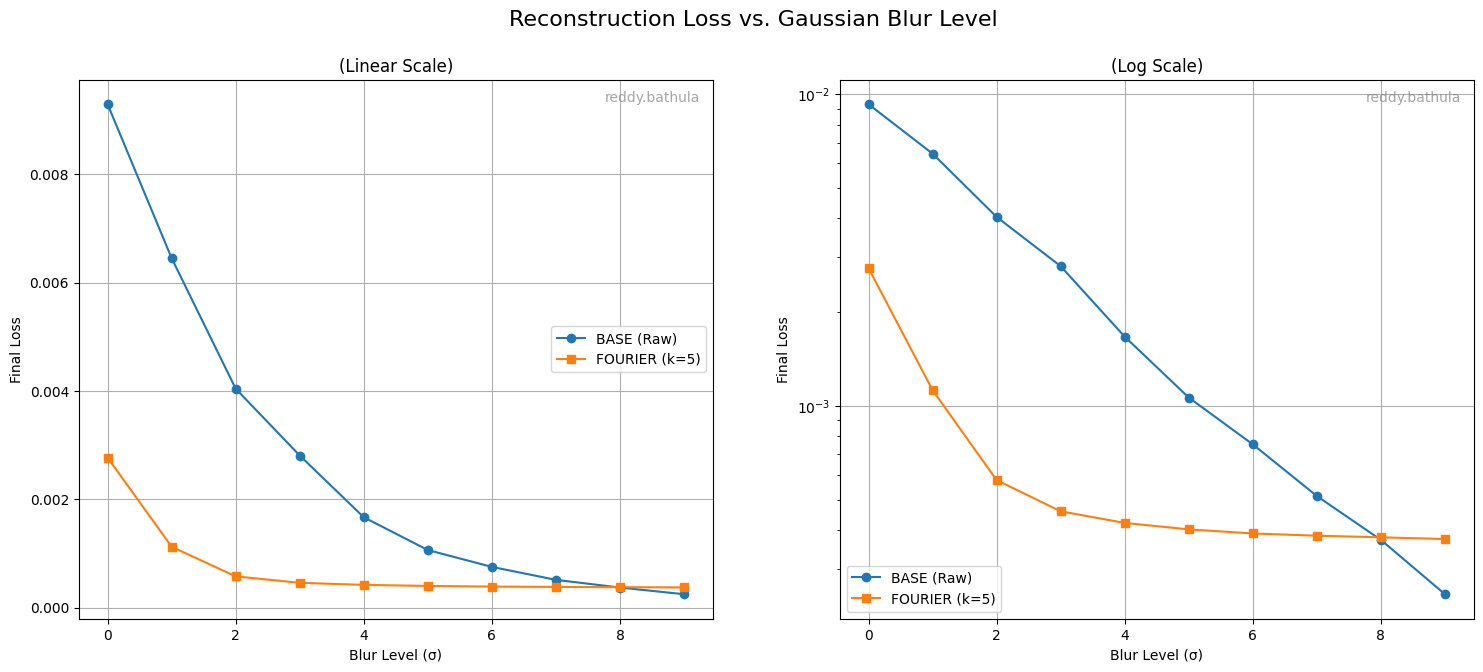

In [42]:
configs, results = [], []
for i in range(11):
    img_path = os.path.join(blurred_dir, f"blur_{i}.png")
    if not os.path.exists(img_path):
        continue
    configs.append({"name":f"blur_{i}_raw", "img_path":img_path, "img_type":"RGB", "feature_config":{"method":"Raw"}, "mlp_config":mlp_config, "train_config":{**train_config, "epochs":100}})
    configs.append({"name":f"blur_{i}_fourier", "img_path":img_path, "img_type":"RGB", "feature_config":{"method":"Fourier", "freq":5}, "mlp_config":mlp_config, "train_config":{**train_config, "epochs":100}})

for config in configs:
    task = ImageReconstructionTask(**config)
    results.append(task.run_pipeline())

plot_blur_analysis(results, username=username)

## Discussion: Reconstruction Performance on Blurred Images

The experiments demonstrate two key trends regarding how image reconstruction performance changes with increasing Gaussian blur:

---

### 🔹 1. Performance Improves as Blur Increases

- **Observation**: Both the BASE (Raw) and FOURIER methods show decreasing reconstruction loss as the Gaussian blur level (σ) increases.
  - The sharpest image (`blur_0`) results in the **highest error**.
  - The most blurred images lead to the **lowest reconstruction loss**.

- **Reason**:
  - Gaussian blur removes high-frequency details (e.g., edges, textures).
  - The resulting image becomes a **simpler and smoother function**.
  - MLPs are inherently biased toward approximating low-frequency, smooth functions.
  - Thus, they perform better (i.e., lower MSE) on blurry images.

- **Conclusion**:
  - Increasing blur simplifies the image, making it easier for the network to reconstruct.

---

### 🔹 2. Fourier Features Consistently Outperform Raw Coordinates

- **Observation**:
  - Across all blur levels, the **FOURIER method outperforms** the BASE method.
  - The **performance gap is largest on sharp images** and narrows as blur increases.

- **Explanation**:
  - BASE coordinates (x, y) are limited to smooth approximations.
  - FOURIER features introduce sine and cosine transformations at multiple frequencies.
  - These help the model capture **high-frequency content** like edges, whiskers, and textures.
  - On sharp images, this leads to significantly better reconstructions.

- **Effect of Blurring**:
  - As blur increases, high-frequency information is lost.
  - This reduces the advantage of Fourier features.
  - However, even for blurry images, FOURIER maintains a lower loss due to its richer representation.

---

### Visual Verification: Reconstructed Images

- **Sharp Image (`blur_0`)**:
  - **BASE**: Likely appears overly smooth or blurry; struggles with fine details.
  - **FOURIER**: Captures sharper edges and textures; closer to the original image.

- **Blurred Image (`blur_10`)**:
  - Both methods produce blurry outputs (since the target is blurred).
  - **Visual difference between BASE and FOURIER is minimal**, but FOURIER still performs slightly better.

---

### Summary

- Increasing blur simplifies the target function → easier learning → lower loss.
- Fourier features allow the model to learn high-frequency patterns effectively.
- They consistently outperform raw coordinates, especially on detailed (sharp) images.
